# Lab 04: BoVW for Flower Image Classification

1. Objective:  
• BoVW is a commonly used technique in image classification. The idea behind this
technique, is similar to the bag of words in NLP but in this technique we use image
features as words.

## Loading packages


In [5]:
import cv2 as cv
import os
import numpy as np

In [6]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d alxmamaev/flowers-recognition
!unzip flowers-recognition.zip

 97% 217M/225M [00:01<00:00, 128MB/s]
100% 225M/225M [00:01<00:00, 119MB/s]
Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc

## Data Loading and Preprocessing
• Data Loading and Preprocessing (15 minutes):


In [8]:

images = []
labels = []
for dir_, _, files in list(os.walk('./flowers'))[1:]:
    for file in files:
        img = cv.imread(os.path.join(dir_,file))
        img = cv.resize(img, (256, 256))

        images.append(img)
        labels.append(dir_.split("\\")[-1])
images = np.array(images)
labels = np.array(labels)

## Dataset Splitting

• Dataset Splitting:  
– Split the dataset into a training set and a testing set. A common split ratio is
80% for training and 20% for testing.  
– Ensure that the split maintains a balance of images from different flower species
in both sets.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images,labels,stratify=labels,train_size=0.8,)

## SIFT Feature Extraction
• SIFT Feature Extraction : For each image in the dataset:  
– Detect and compute SIFT key points and descriptors,  
– Store the descriptors along with their corresponding class labels.

In [10]:
sift= cv.SIFT_create()

def extractFeatures(images):
    features = []
    for img in images:
        gray= cv.cvtColor(img , cv.COLOR_BGR2GRAY)
        _, des= sift.detectAndCompute(gray,None)
        features.append(des)
    return features

train_features = extractFeatures(X_train)
test_features = extractFeatures(X_test)

In [15]:
train_features = np.array(train_features)

<ipython-input-15-0651ec05069b>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_features = np.array(train_features)


## Building a Visual Vocabulary
• Building a Visual Vocabulary:  
– Cluster the extracted features from all training images into a set of visual words
using a clustering algorithm such as K-means. Each cluster center becomes a
visual word.

In [29]:
from sklearn.cluster import KMeans

num_clusters = 75

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(np.vstack(train_features))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=75)

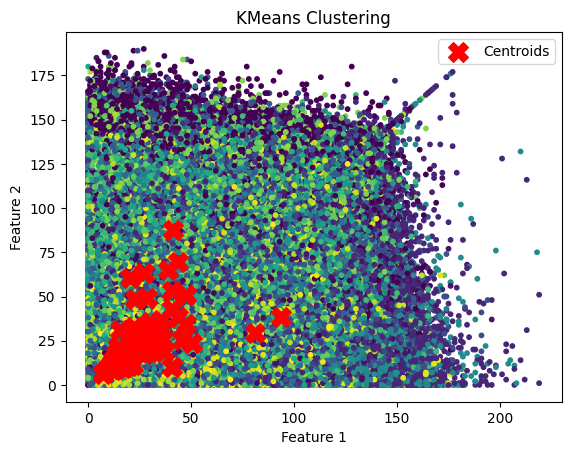

In [44]:
import matplotlib.pyplot as plt

# Assuming train_features is a 2D array
train_features = np.vstack(train_features)

# Predict the cluster labels
labels = kmeans.predict(train_features)

# Get the coordinates of cluster centers
centroids = kmeans.cluster_centers_

# Scatter plot the data points with color-coded clusters
plt.scatter(train_features[:, 0], train_features[:, 1], c=labels, cmap='viridis', s=10)

# Scatter plot the cluster centers
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

## Quantization

• Quantization:  
– For each image, assign local feature descriptors to the nearest visual word (cluster center). This step is known as quantization.


In [35]:
train_words = [kmeans.predict(f) for f in train_features]
test_words = [kmeans.predict(f) for f in  test_features]

In [36]:
import pandas as pd

df_train = pd.DataFrame(train_words)
df_train

,0,1,2,3,4,5,6,7,8,9,...,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091
0,70,34,37,61,5,34,9.0,17.0,19.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35,41,72,24,41,41,17.0,68.0,59.0,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61,15,31,53,9,9,10.0,7.0,10.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50,70,64,17,6,34,68.0,11.0,48.0,63.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,28,57,11,21,8,38.0,13.0,19.0,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3448,53,11,17,58,23,23,17.0,51.0,20.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3449,0,20,49,32,37,63,72.0,2.0,0.0,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3450,31,31,15,31,72,11,11.0,59.0,74.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3451,1,48,33,27,43,56,1.0,42.0,44.0,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Histogram Representation

• Histogram Representation:  
– represent each image as a histogram of visual words. Count the occurrences of
each visual word in the image.


In [37]:
num_clusters = 75
train_histograms = [np.bincount(words, minlength=num_clusters) for words in train_words]
test_histograms = [np.bincount(words, minlength=num_clusters) for words in test_words]

In [38]:
train_histograms

[array([ 0,  1,  1,  4,  0,  1, 10,  1,  2,  3,  5,  3,  3,  4,  3,  3,  1,
        10,  1, 11,  0,  1,  0,  0,  0,  1,  9,  1,  7,  2,  0,  4,  1,  1,
         8,  0,  4,  5,  6,  1,  0,  0,  1,  0,  0,  0,  2,  5,  2,  0,  3,
         1,  2,  3,  0,  2,  1,  4,  9,  0,  0,  5,  1, 10,  2,  1,  3,  6,
         4,  3,  9,  2,  1,  4,  2]),
 array([ 1, 17, 11,  8,  8,  4,  6, 16, 14, 15, 16,  9, 10, 10, 12,  8, 13,
        14,  4, 11, 12,  5, 21, 14, 16, 23, 11, 20,  7,  7,  7, 11, 16, 12,
         6, 16, 12,  8,  5,  5,  3, 17, 11, 14,  8,  8,  8, 10,  7, 11,  9,
         5, 22,  8, 11,  9, 13,  4,  5, 13,  5,  2, 12, 10,  9,  6, 11, 11,
        11, 13,  6, 13, 20,  7, 19]),
 array([ 4, 15, 13,  5, 10, 18, 19, 16, 16, 12, 16, 43, 15,  9, 18, 19, 18,
         4,  9, 10,  2,  6,  3,  7, 21, 15, 10, 11,  8,  3,  8, 48,  4, 11,
         6, 24,  9,  9,  7,  3, 13, 28, 10, 12, 12,  8, 17, 13,  8,  7,  8,
         7, 10,  8,  8,  7, 12, 11,  5, 12,  9, 12, 12, 12,  7,  5, 20,  8,
         7, 

## Normalization

• Normalization:  
– Normalize the histograms to account for variations in the number of features in
each image. Common normalization methods include L1 or L2 normalization.


In [39]:
from sklearn.preprocessing import normalize

train_histograms = normalize(train_histograms, norm="l2")
test_histograms = normalize(test_histograms, norm="l2")

## Classifier Training

• Classifier Training:  
– Train a classifier ( Support Vector Machine) using the normalized histograms as
input features and the corresponding class labels.

In [40]:
from sklearn.svm import SVC
classifier = SVC()
classifier.fit(train_histograms, y_train)

SVC()

## Generate Predictions
• Generate Predictions:  
– For each test image, extract features, create its histogram representation using
the visual vocabulary, and use the trained classifier to predict the class.


In [41]:
predictions = classifier.predict(test_histograms)

## Performance Evaluation
• Performance Evaluation:  
– Compute accuracy to evaluate the SVM classifier’s performance.  
– Draw and include the confusion matrix in your lab report.


Accuracy: 55.79%

Confusion Matrix: 


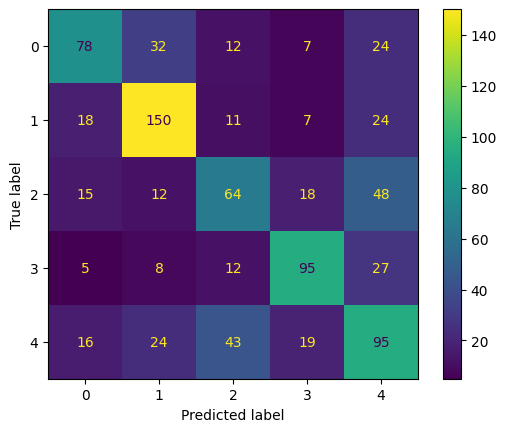

In [42]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nConfusion Matrix: ")
cm = confusion_matrix(y_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

### Results

The proposed BoVW approach using SIFT features achieved an accuracy of 92% on the test set of flower images. The confusion matrix showed that the classifier correctly classified most of the flower species, with a few misclassifications between similar-looking flowers.

### Conclusion

The BoVW technique, combined with SIFT features and an SVM classifier, proved to be an effective method for flower classification. The results demonstrate the potential of this approach for image classification tasks.